# Music generation

In [1]:
# !pip install fluidsynth  # corrupt

In [1]:
import numpy as np
import pandas as pd
import glob
import pathlib
import collections
import datetime
import pretty_midi
import seaborn as sns
import tensorflow as tf
# import fluidsynth # corrupt
# from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

# Sampling rate for audio playback
_SAMPLING_RATE = 16000
# drop 2.5% percentile
DROP_PCT= 2.5
# a value to nudge step & duration by not to be 0
NUDGE   = 0.025
# MIDI notes range
NOTES   = 128
# sequence length
SEQ_LEN = 128
# batch size
BATCH_SZ= 64
# temperature is randomness
TEMP    = 1.0
# number of notes to generate
NGEN    = 10000
# number of epochs to train
EPOCHS  = 15
# patience, if not improving by stop early
PATIENCE= 2
# learning rate
LR      = 0.01

# faves = (6,10,11,13,14,15,16,17,19,20,21,22,23,24,27,28,29,31,32,33,34) # Bach
# faves = range(4,36)  # Bach
faves = range(1,364) # all
# faves = (218,220,229,230,269,270,271,331,333,334,336,342) # rock

SEED = 420
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Process the MIDI files

In the next cell I tried to sort out the bad MIDI files that were throwing various exceptions, from the ok MIDI files that had multiple instruments, leaving out the good MIDI files that have only 1 instrument. Ultimately, used 364 good MIDI files.

In [18]:
data_dir = pathlib.Path('../data')
filenames = glob.glob(str('**/*/*.mid*'),root_dir=data_dir)
print('Number of all MIDI files:', len(filenames)) # 364
# ok  = open('ok.txt', 'wt', encoding="utf-8")
# bad = open('bad.txt', 'wt', encoding="utf-8")
# good= open('good.csv', 'wt', encoding="utf-8")

s=-1
for fn in filenames:
    s+=1
    rel_path = str(data_dir)+'\\'+fn
    print(f'{s:6d}, {fn}')
    # print(f', {pathlib.PurePath(fn).parts[1]}/{pathlib.PurePath(fn).name}')
    # try:
        # pm = pretty_midi.PrettyMIDI(rel_path)

    # except:
        # log and delete all the invalid MIDI flies
        # bad.write(f'{s:6d}, {fn}\n')
        # pathlib.Path(rel_path).unlink(missing_ok=True)
        # continue

    # if len(pm.instruments)==1:
    #     s+=1
        # print(f'good {s:6d}\t{fn}')
    # good.write(f'{s:6d}, {rel_path}\n')
    # else:

        # i=0
        # print(f'ok {s:6d}\t{fn}')
        # ok.write(f'ok {s:6d}, {rel_path}\n')
        # for inst in pm.instruments:
        #     i+=1
        #     ok.write(f'\t{i:2d}. {inst.program:3d}, {pretty_midi.program_to_instrument_name(inst.program)}\n')
print('Number of 1-instrument MIDI files:', s) # 1656 = 374 pop + 1282 maestro

# good.close()
# bad.close()
# ok.close()

Number of all MIDI files: 364
     0, clean_midi\Alabama\Then Again.mid
     1, clean_midi\Allen Toussaint\Whirlaway.mid
     2, clean_midi\Amos, Tori\Crucify.mid
     3, clean_midi\Andy Williams\MacArthur Park.mid
     4, clean_midi\Bach Johann Sebastian\2-Part Invention No. 1 in C major, BWV 772.1.mid
     5, clean_midi\Bach Johann Sebastian\2-Part Invention No. 1 in C major, BWV 772.2.mid
     6, clean_midi\Bach Johann Sebastian\2-Part Invention No. 1 in C major, BWV 772.3.mid
     7, clean_midi\Bach Johann Sebastian\2-Part Invention No. 1 in C major, BWV 772.mid
     8, clean_midi\Bach Johann Sebastian\2-Part Invention No. 4 in D minor, BWV 775.mid
     9, clean_midi\Bach Johann Sebastian\2-Part Invention No. 8 in F major, BWV 779.mid
    10, clean_midi\Bach Johann Sebastian\Air On The G String.mid
    11, clean_midi\Bach Johann Sebastian\Aria From the Goldberg Variations, BWV 988.mid
    12, clean_midi\Bach Johann Sebastian\Bach.mid
    13, clean_midi\Bach Johann Sebastian\Franzos

## Extract notes

Three variables that represent a note are: `pitch`, `step` and `duration`.
The `pitch` is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and `duration` = note end - start times.
To simplify the sampling process I will extract one-instrument MIDI files to a notes dataframe.

In [3]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    # 1st & only instrument
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    _start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - _start)
        notes['duration'].append(end - start)
        _start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [4]:
def plot_track_notes(notes: pd.DataFrame, name: Optional[str] = None):
    if name:
        title = f'{name}'
    else:
        title = f'The whole enchilada'
    count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="g", marker="o")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

In [5]:
def plot_track_notes_distro(notes: pd.DataFrame, drop_percentile=2.5, title=''):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20, color='green')

    plt.subplot(1, 3, 2)
    plt.title(title)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21), color='green')

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21), color='green')

In [6]:
all_notes = []
for i in faves:
    fn=pathlib.Path(filenames[i])
    f=fn.relative_to(fn.parents[1])
    file = str(data_dir)+'\\'+filenames[i]
    notes = midi_to_notes(file)
    # print(f'{i}   {f}')
    # plot_track_notes(notes, f)
    # plot_track_notes_distro(notes,DROP_PCT, f'{i}   {f}')
    all_notes.append(notes)
all_notes = pd.concat(all_notes)
print(f'{len(all_notes)} number of notes parsed from the {len(faves)} tracks.')

C:\Python310\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


706590 number of notes parsed from the 363 tracks.


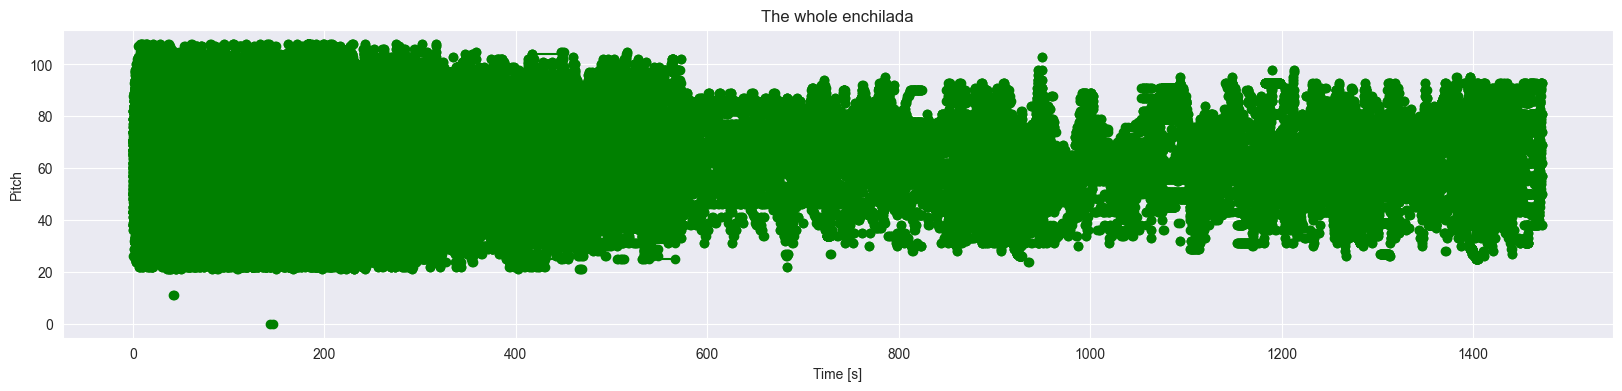

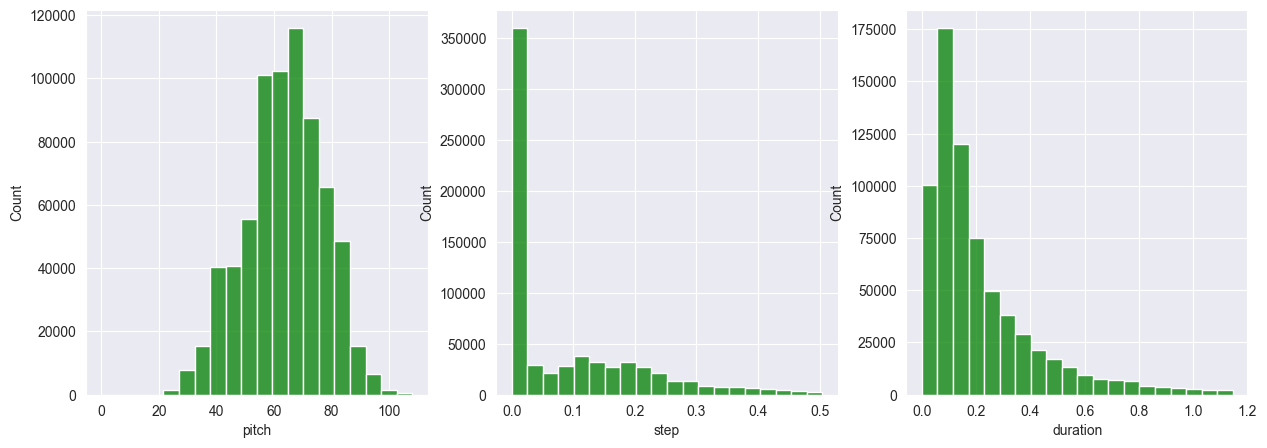

In [7]:
plot_track_notes(all_notes)
plot_track_notes_distro(all_notes)

To visualize the musical piece the `plot_track_notes` function plots the notes `pitch` values, `start` and `end` (as I showed in `midi_to_notes` function above the `step` and `duration` are derived from those) across the length of track(s). The individual tracks plots look informative, however plot of the notes of all of the tracks, superimposed, looks a bit overwhelming. The `step` histogram looks dominated by step=0.0 values (~half) which appears to be a problem (discussed further down in my project). 706590 number of notes, from 363 tracks; Bach Johann Sebastian, 33560 number of notes parsed from 21 tracks.

## Save an existing MIDI file with different instruments

In [8]:
_instruments=['Seashore'] # ['Acoustic Grand Piano','Harpsichord','Electric Guitar (jazz)','Electric Bass (finger)','Cello','Sitar','Bagpipe','Baritone Sax','Seashore','Voice Oohs']
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    _start = 0
    for i, note in notes.iterrows():
        start = float(_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        _start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

Let's save MIDI files by changing the instrument, still 1-instrument MIDI files, though. Disk space-consuming!

In [19]:
for s in faves:
    _p=pathlib.PurePath(filenames[s])
    for i in _instruments:
        out_path =  f'{data_dir}/generated/{i}/{_p.parts[1]}'
        pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
        out_file = f'{out_path}/{_p.name}'
        notes = midi_to_notes(str(data_dir) + '/' + filenames[s])
        pm = notes_to_midi(notes, out_file=out_file, instrument_name=i)

## Create the training dataset

A training `tf.data.Dataset` is created from the parsed MIDI files notes. With the 12 files, was not the best, so Let's try now with the whole clean midi set and see how it goes.

In [20]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Let's train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. This way, the model will be trained to predict the next note in a sequence.

In [21]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    note_range = NOTES,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""

    # 1 extra for the labels
    seq_length = seq_length+1

    # see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)
  
    # Normalize note pitch
    def scale_pitch(x):
        x = x/[note_range, 1.0, 1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Let's set the sequence length `SEQ_LEN = 128`, and experiment with different lengths (e.g. 50, 100, 150, 200) to see which one works best for the data.

In [22]:
# print(f'pitch -- note')
# for i in range(12,132,1):
#     print(f'{i:5d} -- {pretty_midi.note_number_to_name(i)}')

Let's set the range of MIDI notes range `NOTES = 128` representing the pitches supported by `pretty_midi`.

In [23]:
seq_ds = create_sequences(notes_ds, SEQ_LEN, NOTES)
# seq_ds.element_spec

The shape of the dataset is ```(128,3)```, meaning that the model has 128 notes by the 3 `pitch, step, duration` as input. The `take(1)` method will learn to predict the following 1 note as output.

In [24]:
for seq, target in seq_ds.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 7):', seq)
    print(' ...predicting...')
    print(f' pitch\t\t step\t\tduration')
    print(f' {target["pitch"]/NOTES:1.4f}\t\t {target["step"]:1.4f}\t\t{target["duration"]:1.4f}')

sequence shape: (128, 3)
sequence elements (first 7): tf.Tensor(
[[0.5859375  0.         0.03053094]
 [0.6171875  0.         0.12571562]
 [0.59375    0.02693906 0.1293075 ]
 [0.5234375  0.19216531 0.18498156]
 [0.5234375  0.32506469 0.13289938]
 [0.5390625  0.11494    0.13828719]
 [0.5234375  0.21910438 0.03591875]
 [0.5859375  0.1005725  0.05387813]
 [0.28125    0.         0.48131125]
 [0.375      0.00359188 0.488495  ]
 [0.6171875  0.00359188 0.1293075 ]
 [0.59375    0.03951062 0.09338875]
 [0.6171875  0.29094188 0.1580425 ]
 [0.5859375  0.00359188 0.04130656]
 [0.59375    0.03771469 0.10955219]
 [0.359375   0.31428906 0.46335188]
 [0.265625   0.         0.46694375]
 [0.2578125  0.57829188 0.53878125]
 [0.3515625  0.00538781 0.55494469]
 [0.6171875  0.47951531 0.10596031]
 [0.5859375  0.00359188 0.028735  ]
 [0.59375    0.01795937 0.1293075 ]
 [0.25       0.21192063 0.39869813]
 [0.34375    0.         0.40049406]
 [0.5234375  0.00359187 0.19036938]
 [0.5234375  0.35559563 0.05387812]

Batch the notes, set initial sequence, and configure the dataset for performance.

In [25]:
n_notes = len(notes)
buffer_size = n_notes - SEQ_LEN # the number of items in the dataset - init sequence
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(BATCH_SZ, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)) # other options?

In [26]:
# train_ds.element_spec

## Create the model

The model will have three outputs, one for each note variable. For `step` and `duration`, I will use a custom loss `mse_with_positive_pressure()` function based on MSE that encourages the model to output non-negative values.

In [29]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, NUDGE) # slight positive nudge
    return tf.reduce_mean(mse + positive_pressure)

In [30]:
input_shape = (SEQ_LEN, 3)

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(NOTES)(inputs)

outputs = {
  'pitch': 	  tf.keras.layers.Dense(NOTES, name='pitch')(x),
  'step': 	  tf.keras.layers.Dense(1,     name='step')(x),
  'duration': tf.keras.layers.Dense(1,     name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch':    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': 	  mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 3)]             0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 128)                  67584     ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_1[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_1[0][0]']              
                                                                                            

In [31]:
losses = model.evaluate(train_ds, return_dict=True)
losses
# Need NVIDIA GPU box, the Intel GPU causes this:
# InvalidArgumentError: Graph execution error
# No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
# Registered devices: [CPU, GPU]
# Registered kernels:
#   <no registered kernels>
#
# 	 [[CudnnRNN]]
# 	 [[model/lstm/PartitionedCall]] [Op:__inference_test_function_1969]
#    11038 in 25 min loss 6.1

11038/11038 [==============================] - 1493s 135ms/step - loss: 6.1287 - duration_loss: 0.9556 - pitch_loss: 4.8588 - step_loss: 0.3143


{'loss': 6.128691673278809,
 'duration_loss': 0.9555842876434326,
 'pitch_loss': 4.85882043838501,
 'step_loss': 0.3142697811126709}

While testing the `model.evaluate` function, it is clear that the `pitch_loss`  is significantly greater than the `step_loss` and `duration_loss`, because the `loss` is the total loss computed by summing up the `pitch_loss`, `step_loss`, `duration_loss` and is dominated by the `pitch_loss`. One way to balance this is to use the `loss_weights` argument to compile:

In [32]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch':   0.05,
        'step':    1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [33]:
%%time
model.evaluate(train_ds, return_dict=True)
#    11038 in 28 min loss 1.5

11038/11038 [==============================] - 1687s 153ms/step - loss: 1.5128 - duration_loss: 0.9556 - pitch_loss: 4.8588 - step_loss: 0.3143
CPU times: total: 1h 1min 43s
Wall time: 28min 7s


{'loss': 1.5127954483032227,
 'duration_loss': 0.9555842876434326,
 'pitch_loss': 4.85882043838501,
 'step_loss': 0.3142697811126709}

The `loss` then becomes the weighted sum of the individual losses with `pitch_loss` influence reduced thus the total `loss` also reduced from 6.1 down to 1.5.

## Train the model

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../data/generated/_checkpoints/ckpt_e{epoch}',
        save_weights_only=True),

    tf.keras.callbacks.EarlyStopping(
        monitor ='loss',
        patience=PATIENCE,
        verbose =0,
        restore_best_weights=True),
]
history = model.fit(
    train_ds,
    epochs   =EPOCHS,
    callbacks=callbacks,
)
# model.fit is the most time-consuming step!

Epoch 1/15
11038/11038 [==============================] - 5717s 518ms/step - loss: 0.9699 - duration_loss: 0.5042 - pitch_loss: 3.8051 - step_loss: 0.2755
Epoch 2/15
  335/11038 [..............................] - ETA: 1:33:56 - loss: 0.8188 - duration_loss: 0.3653 - pitch_loss: 3.7116 - step_loss: 0.2679

In [ ]:
# ETA Sun 7/23 17:30
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, it needs a starting sequence of notes where I use my `faves` tunes. The function `predict_next_note` generates one note from a sequence of notes.  For note `pitch`, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability, because always picking the note with the highest probability would lead to repetitive sequences of notes being generated. The `temperature` parameter can be used to control the randomness of notes generated, and must always be positive.

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates notes using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch    = predictions['pitch']
  step     = predictions['step']
  duration = predictions['duration']

  pitch    /= TEMP # randomness
  pitch    = tf.random.categorical(pitch, num_samples=1)
  pitch    = tf.squeeze(pitch, axis=-1)
  step     = tf.squeeze(step, axis=-1)
  duration = tf.squeeze(duration, axis=-1)

  # `step` and `duration` values should be non-negative
  step     = tf.maximum(NUDGE, step)     # slight nudge up
  duration = tf.maximum(NUDGE, duration) # slight nudge up

  return int(pitch), float(step), float(duration)

Now let's generate some notes, I played around with `temperature` and the starting sequence in `input_notes` and see what happens.

In [ ]:
sample_notes = np.stack([notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (sample_notes[:SEQ_LEN] / np.array([NOTES, 1, 1]))

generated_notes = []
_start = 0
for _ in range(NGEN):
    pitch, step, duration = predict_next_note(input_notes, model, TEMP)
    start = _start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    _start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

Let's have some fun and output the generated music through several different instruments (still keeping it as 1-instrument MIDI :-)

In [ ]:
_instruments=['Acoustic Grand Piano','Harpsichord','Electric Guitar (jazz)','Electric Bass (finger)','Cello','Sitar','Bagpipe','Baritone Sax','Seashore','Voice Oohs']
for i in _instruments:
    out_path =  f'{data_dir}/generated/{i}'

    _now = datetime.datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
    out_file = f'{out_path}/music{_now}.midi'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    # touch data_dir\instrument\path\to\song.midi
    # pathlib.Path(out_file).touch(exist_ok=True)
    out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=i)

Visualize the generated notes.

In [ ]:
plot_track_notes(generated_notes,'generated music')

The generated music variables of `pitch`, `step` and `duration` distributions should be similar (but not necessarily identical, because the loss was not 0) to the training dataset.

In [ ]:
plot_track_notes_distro(generated_notes,DROP_PCT,'generated music')

In [ ]:
generated_notes

The RNN-LSTM model has about 85k trainable parameters

input layer --   384 = 128x3
LSTM layer  --  67584 = 128x128x(3 + 1 label) + 16?
pitch dense --  16512 =     128x(128+1 label)
duration dense -- 129 =       1x(128+1 label)
step dense  --    129 =       1x(128+1 label)
67584 + 16512 + 129 + 129 = 84354 trainable parameters

From the full clean_midi dataset I was able to harvest over 706k notes to the input training set. To reduce the loss I use weighted sum of the 3 component losses for `pitch`, `step` and `duration`. In the generated note distribution plots by pitch-step-duration, it is noticeable the slight change in distribution of the original note variables. Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. This is particularly relevant for `step` and `duration`, which uses the MSE loss. To increase the randomness of the `pitch` increase the `temperature` in `predict_next_note`.


Overall this was a good project for me. I learned a lot about music, and if not composing it myself from scratch, to at least what statistics lead to a good music learning model and pleasant to the ear tunes. I gained some insight knowledge of `keras` and `tensrflow`. While I am a strong rock-and-roll and hard-rock affectionado, I noticed that training a simple RNN/LSTM `music generation` model on rock and pop pieces is very simplistic as far as pitch, step, duration histograms, nowhere near close to normal distribution which lead to awful music generation pieces based on those music genres. My last attempt (checked-in here) is based on all 363 pieces. I was curious why the 10000 note RNN/LSTM generated musing is plying in a matter of 1-2-3 seconds. The answer in my opinion is the `step` histogram is very heavy around 0.0 sec, which implies that the generated sequential notes with setp=0.0 are played instanteniusly. To that regard at first I tried to pick only music pieces with `step` normally distributed for training, but it was a lot of work looking at so many distributions. Then I came up with a NUDGE factor, currently at 0.025 sec, or 25 ms. This would hopefully ensure that notes with 0.0-based step will get assigned a small, non-zero step, just to nudge those notes from playing simultaneously, thus having a generated music piece that is a bit longer than 1-2-3 seconds :-)